In [1]:
# %% [Install Dependencies]
import torch
# !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q pytorch-lightning pytorch-metric-learning plotly

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 61.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 46.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.2 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-jhu0a_wr
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-jhu0a_wr
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit afffee9f089ac0fe1eb8c1600c6e0b2e07ca6f80
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=11

In [2]:

import pytorch_lightning as pl
from torch_geometric.data import DataLoader
from torch_geometric.datasets import ModelNet
from torch_geometric.nn import MLP, DynamicEdgeConv, global_max_pool
from torch_geometric.transforms import SamplePoints, RandomJitter, RandomFlip, Compose
from pytorch_metric_learning.losses import NTXentLoss
import plotly.graph_objects as go
from pathlib import Path
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# %% [Dataset Setup - Final]
from torch_geometric.transforms import SamplePoints, RandomJitter, RandomFlip

class ModelNet10DataModule(pl.LightningDataModule):
    CLASS_NAMES = [
        'bathtub', 'bed', 'chair', 'desk', 'dresser',
        'monitor', 'night_stand', 'sofa', 'table', 'toilet'
    ]
    
    def __init__(self, batch_size=32, num_points=1024):
        super().__init__()
        self.batch_size = batch_size
        self.num_points = num_points
        self.base_transform = SamplePoints(num_points)
        self.augmentation = Compose([
            RandomJitter(0.03),
            RandomFlip(1)  # Removed RandomShear
        ])

    def setup(self, stage=None):
        self.train_dataset = ModelNet(
            root='./ModelNet10',
            name='10',
            train=True,
            transform=self.base_transform
        )
        self.val_dataset = ModelNet(
            root='./ModelNet10',
            name='10',
            train=False,
            transform=self.base_transform
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=2
        )

In [4]:
# %% [Model Definition - Fixed]
class PointCloudContrastive(pl.LightningModule):
    def __init__(self, lr=1e-3, temperature=0.1):
        super().__init__()
        self.save_hyperparameters()
        
        # Architecture components
        self.conv1 = DynamicEdgeConv(MLP([2*3, 64, 64]), k=20, aggr='max')
        self.conv2 = DynamicEdgeConv(MLP([2*64, 128]), k=20, aggr='max')
        self.projection_head = MLP([128+64, 256, 128], norm=None)
        
        # Loss function
        self.criterion = NTXentLoss(temperature=temperature)

    def forward(self, data):
        # Ensure all tensors are on the same device
        x1 = self.conv1(data.pos.to(self.device), data.batch.to(self.device))
        x2 = self.conv2(x1, data.batch.to(self.device))
        h_points = self.projection_head(torch.cat([x1, x2], dim=1))
        return global_max_pool(h_points, data.batch.to(self.device))

    def training_step(self, batch, batch_idx):
        # Augmentation and loss calculation
        aug1 = batch.clone()
        aug1.pos = torch.cat([self.trainer.datamodule.augmentation(d).pos 
                            for d in batch.to_data_list()])
        
        aug2 = batch.clone()
        aug2.pos = torch.cat([self.trainer.datamodule.augmentation(d).pos 
                            for d in batch.to_data_list()])

        z1 = self(aug1)
        z2 = self(aug2)
        
        # Create contrastive labels
        labels = torch.arange(z1.size(0), device=self.device)
        loss = self.criterion(torch.cat([z1, z2]), torch.cat([labels, labels]))
        
        self.log('train_loss', loss, prog_bar=True)
        return loss

    # REQUIRED FOR LIGHTNING
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, 
            step_size=20, 
            gamma=0.5
        )
        return [optimizer], [scheduler]

In [5]:
# %% [Visualization - Fixed Labels]
def plot_sample(data, title=""):
    pos = data.pos.cpu().numpy()
    label_idx = data.y.item() if hasattr(data, 'y') else 0
    class_name = ModelNet10DataModule.CLASS_NAMES[label_idx]
    
    fig = go.Figure(data=[go.Scatter3d(
        x=pos[:,0], y=pos[:,1], z=pos[:,2],
        mode='markers',
        marker=dict(size=3, opacity=0.8, color=pos[:,2], colorscale='Viridis')
    )])
    fig.update_layout(
        title=f"{class_name}: {title}",
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        width=800,
        height=600
    )
    fig.show()

def check_class_distribution(dataset):
    class_counts = {name: 0 for name in ModelNet10DataModule.CLASS_NAMES}
    for data in dataset:
        class_counts[ModelNet10DataModule.CLASS_NAMES[data.y]] += 1
    print("Class distribution:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count} samples")

def visualize_augmentations(dm):
    # Get original samples from different classes
    sample_indices = [
        next(i for i, d in enumerate(dm.train_dataset) if d.y == class_idx)
        for class_idx in range(5)  # First 5 classes
    ]
    
    for idx in sample_indices:
        original = dm.train_dataset[idx]
        plot_sample(original, "Original")
        
        # Create augmented version
        augmented = original.clone()
        augmented.pos = dm.augmentation(augmented).pos
        plot_sample(augmented, "Augmented")
        
def visualize_embeddings(model, datamodule, device, title=""):
    model.eval()
    with torch.no_grad():
        # Get sample batch and move to device
        loader = datamodule.train_dataloader()
        sample = next(iter(loader))
        sample = sample.to(device)  # Move entire batch to device
        
        # Get representations
        h = model(sample)
        h = h.cpu().numpy()
        labels = [datamodule.CLASS_NAMES[y] for y in sample.y.cpu().numpy()]

        # t-SNE dimensionality reduction
        tsne = TSNE(n_components=2, perplexity=15, random_state=42)
        h_embedded = tsne.fit_transform(h)

        # Plot
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x=h_embedded[:,0], y=h_embedded[:,1], 
                        hue=labels, palette="tab10", alpha=0.7)
        plt.title(f"t-SNE Embeddings {title}")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

In [6]:
# Check PyG version
import torch_geometric
print(torch_geometric.__version__)  # Should be ≥ 2.4.0

# If version ≥ 2.4.0, you can safely use RandomShear

2.7.0


Extracting ModelNet10/ModelNet10.zip
Processing...
Done!


Before training:


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


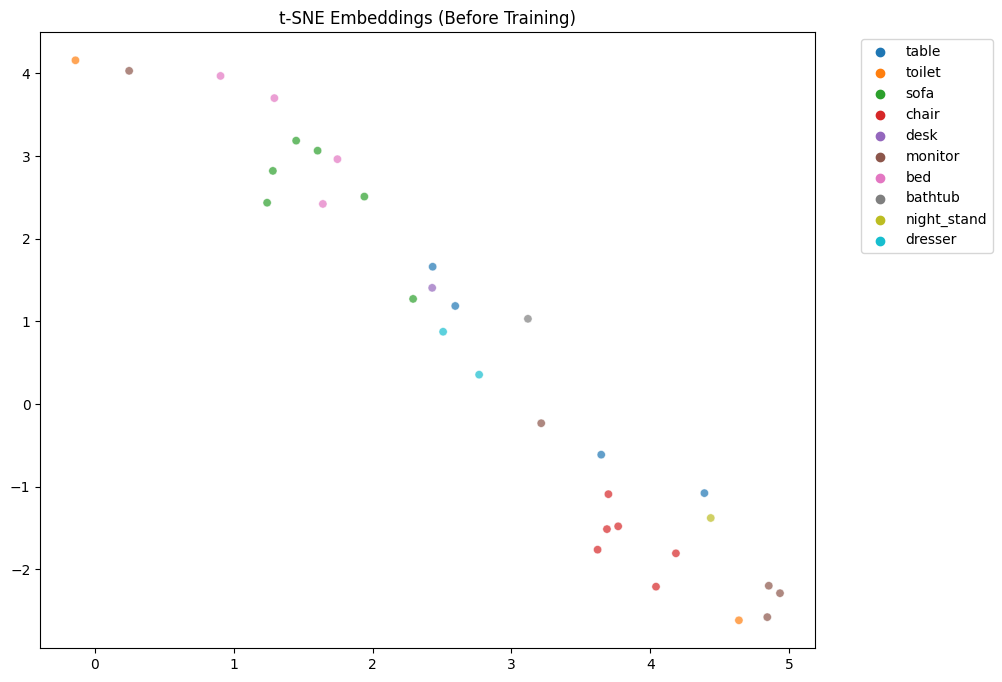

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Training: |          | 0/? [00:00<?, ?it/s]


After training:


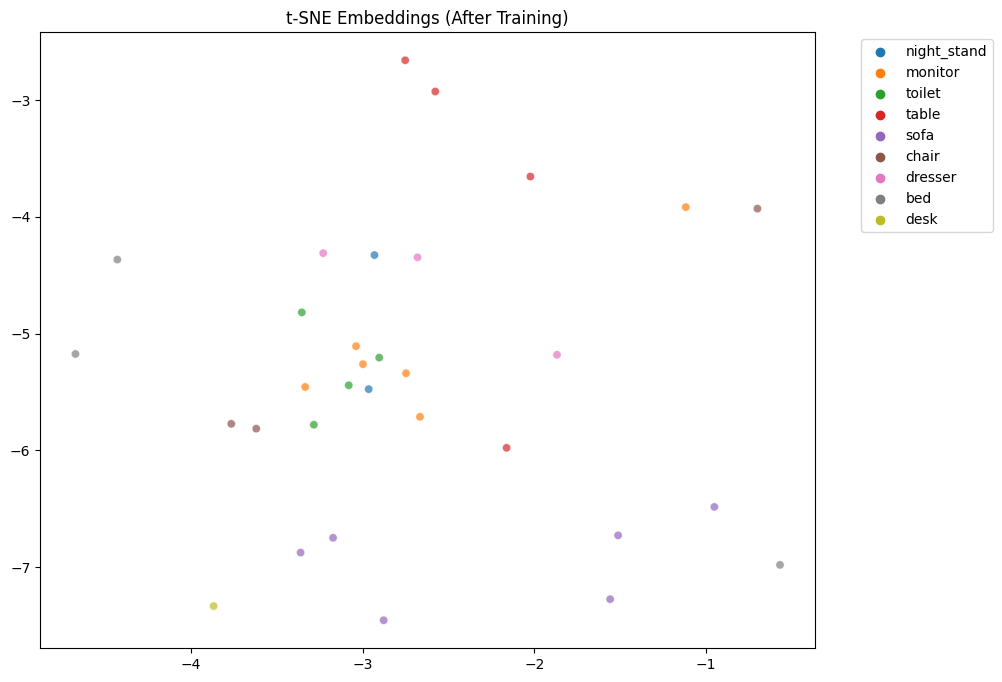

In [7]:
# %% [Training Execution - Corrected]
if __name__ == "__main__":
    # Initialize components
    dm = ModelNet10DataModule(batch_size=32)
    model = PointCloudContrastive(lr=1e-3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize dataset first
    dm.setup()  # <--- THIS IS CRUCIAL
    
    # Initial visualization
    print("Before training:")
    model.to(device)
    visualize_embeddings(model, dm, device, "(Before Training)")
    
    # Train model
    trainer = pl.Trainer(
        max_epochs=3,
        accelerator='auto',
        devices=1,
        log_every_n_steps=10
    )
    trainer.fit(model, dm)
    
    # Post-training visualization
    print("\nAfter training:")
    visualize_embeddings(model, dm, device, "(After Training)")
    
    # Save model
    torch.save(model.state_dict(), 'contrastive_model.pt')

In [8]:
# Should output balanced classes
check_class_distribution(dm.train_dataset)

Class distribution:
bathtub: 106 samples
bed: 515 samples
chair: 889 samples
desk: 200 samples
dresser: 200 samples
monitor: 465 samples
night_stand: 200 samples
sofa: 680 samples
table: 392 samples
toilet: 344 samples


In [9]:
# Should show matching class labels for original/augmented pairs
visualize_augmentations(dm)